In [ ]:
import numpy as np
import matplotlib
import matplotlib.image as image
import matplotlib.pyplot as plt
from skimage.transform import AffineTransform, ProjectiveTransform, warp
%matplotlib notebook
                    # NOTE: all "magic" options for backend plotting are: inline, notebook, and "external" (default) 
                     # see  http://ipython.readthedocs.io/en/stable/interactive/plotting.html for details

### LineBuilder class for entering correspoinding points in each image
###### Note: left mouse clicks add polyline intervals, the right mouse click terminates the polyline, 'DEL' key removes the last click point

In [ ]:
class LineBuilder:

    def __init__(self, axes, line):
        self.line = line
        self.ax = axes
        self.xs = list(line.get_xdata())
        self.ys = list(line.get_ydata())
        self.dashed_line = plt.Line2D((0,0),(0,0), color = line.get_c(), ls=':', lw=line.get_linewidth())
        self.terminated = False
        
        self.connect()
        
    def connect(self):
        # 'connect to all the events we need'
        self.cidpress = self.ax.figure.canvas.mpl_connect('button_press_event', self.on_click)
        self.cidmotion = self.ax.figure.canvas.mpl_connect('motion_notify_event', self.on_motion)
        self.cidkey = self.ax.figure.canvas.mpl_connect('key_press_event', self.on_key_down)

        
    def on_click(self, event):
        if ((self.terminated==True) or (event.inaxes!=self.line.axes)): return
        self.xs.append(event.xdata)
        self.ys.append(event.ydata)
        self.line.set_data(self.xs, self.ys)
        #self.ax.add_patch(plt.Circle((event.xdata,event.ydata), radius=5, fc='y'))
        self.line.figure.canvas.draw()
        if (event.button==3): self.terminated = True   #right mouse click terminates the polyline 
            
    def on_motion(self, event):
        if ((self.terminated==True) or (event.inaxes!=self.line.axes) or (len(self.xs)==0)): return
        self.dashed_line.set_xdata([self.xs[-1],event.xdata])
        self.dashed_line.set_ydata([self.ys[-1],event.ydata])
        self.ax.add_line(self.dashed_line)
        
    def on_key_down(self, e): # do the following when certain "key" is pressed
        if (e.inaxes!=self.ax.axes): return
        if e.key == 'delete' :  # pressing 'DELETE' key deletes the last click
            if self.xs : self.xs.pop()
            if self.ys : self.ys.pop()
            self.line.set_data(self.xs, self.ys)
            self.dashed_line.set_xdata([])
            self.dashed_line.set_ydata([])
            self.line.figure.canvas.draw()
            self.terminated = False
    
    def disconnect(self):
        # 'disconnect all the stored connection ids'
        self.ax.figure.canvas.mpl_disconnect(self.cidmotion)   
        self.ax.figure.canvas.mpl_disconnect(self.cidpress)
        self.ax.figure.canvas.mpl_disconnect(self.cidkey)

### CrossDissolver class
###### Note: click on the left side to move back to image A, clicks on the right side to move forward to image B

In [ ]:
# ASSUMPTION: images A and B should have the same size and the same data type ('uint8' {0,1,2,...,255} or 'float' [0,1])
class CrossDissolver:

    def __init__(self, axes, imA, imB, dtype = 'uint8'):
        self.ax = axes
        scaler = 1.0/255.0
        if (dtype == 'float') : scaler = 1.0
        self.A = scaler * np.array(imA)    # generating array A with (RGB) float values in the range [0,1]
        self.B = scaler * np.array(imB)    # generating array B with (RGB) float values in the range [0,1]
        self.t = 0.5
        self.width = imA.shape[1]
        self.text_pos = (self.width+20, 20)                 
        self.cidpress = self.ax.figure.canvas.mpl_connect('button_press_event', self.on_click)
        self.showMix()       
                            
    def on_click(self, event):
        if (event.inaxes!=self.ax.axes): return
        if (event.xdata>(self.width/2)):  self.t = min(1.0,self.t+0.1)
        if (event.xdata<(self.width/2)):  self.t = max(0.0,self.t-0.1)           
        self.showMix()
         
    def showMix(self):
        self.ax.imshow((1.0-self.t)*self.A + self.t*self.B)
        self.ax.text(self.text_pos[0], self.text_pos[1], 't = {:4.2f}'.format(self.t), color='y', backgroundcolor='gray') 

# Homographies

<IPython.core.display.Javascript object>


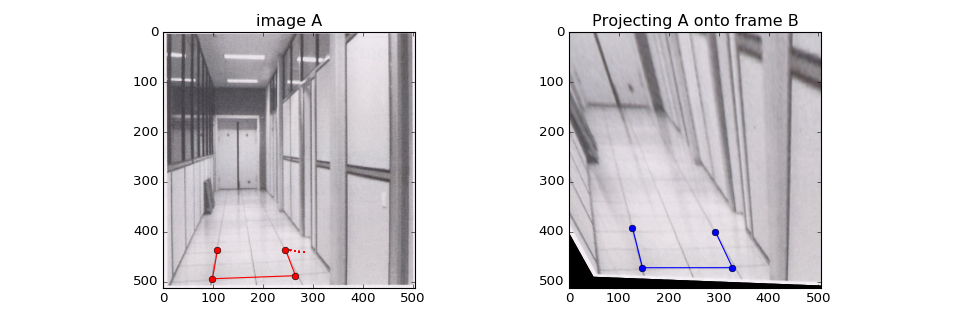

In [4]:
imA = image.imread("images/hall.png")
imB = np.zeros((imA.shape[0],imA.shape[1]), dtype=np.int8)

fig = plt.figure(1,figsize = (12, 4))
axA = plt.subplot(121)
polylineA = LineBuilder(axA, plt.plot([], [], 'ro-')[0] )  # instantiates LineBuilder object
axA.imshow(imA)
plt.title("image A")

axB = plt.subplot(122)
polylineB = LineBuilder(axB, plt.plot([], [], 'bo-')[0] )  # instantiates LineBuilder object
axB.imshow(imB, cmap = "gray")
plt.title("frame B")

# (Left) click on two images below to consecutively enter corresponding points (right clicks enter the last points)
# Press "DEL" key to delete the last click point.
# You should enter at least 4 points (to define a proper homography)

### Warping image A onto frame B using a homographic transofmation (projective map)
###### NOTE: function "warp" uses "inverse map" as a (second) argument as it uses "inverse warping" to compute output intensities

In [5]:
ptsA = polylineA.line.get_xydata()   # extracts a sequnce of 2D points (x,y) from the polyline
ptsB = polylineB.line.get_xydata()

ProjAtoB = ProjectiveTransform()    
ProjAtoB.estimate(ptsA, ptsB)      # computes projective map from points ptsA to points ptsB
imB = warp(imA, ProjAtoB.inverse)

axB.imshow(imB)
axB.set_title("Projecting A onto frame B")

# Panoramas (projective and other transformations)

<IPython.core.display.Javascript object>


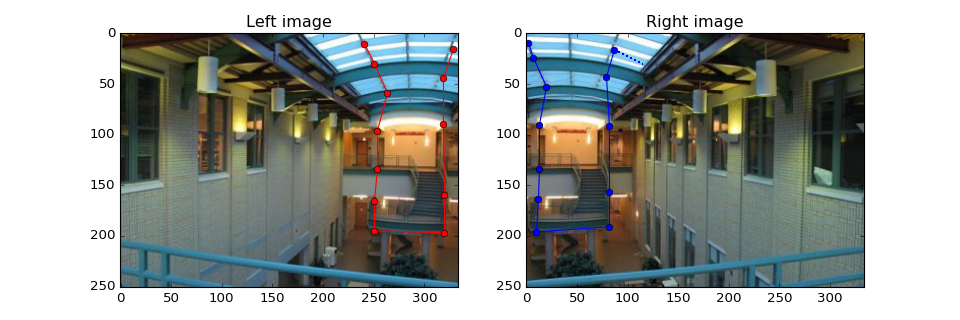

In [6]:
imL = image.imread("images/CMU_left.jpg")
imR = image.imread("images/CMU_right.jpg")

fig = plt.figure(2,figsize = (12, 4))
axL = plt.subplot(121)
polylineL = LineBuilder(axL, plt.plot([], [], 'ro-')[0] )  # instantiates LineBuilder object
axL.imshow(imL)
axL.set_title("Left image")

axR = plt.subplot(122)
polylineR = LineBuilder(axR, plt.plot([], [], 'bo-')[0] )  # instantiates LineBuilder object
axR.imshow(imR)
axR.set_title("Right image")

plt.show()

# (Left) click on two images below to consecutively enter corresponding points (right clicks enter the last points)
# Press "DELETE" key to delete the last click, if necessary.
# You should enter at least 4 points (to define a proper homography)

### Estimate affine and projective transformations between left and right images

In [7]:
ptsL = polylineL.line.get_xydata()    # extracts a sequnce of 2D points (x,y) from the polyline
ptsR = polylineR.line.get_xydata()

AffLtoR = AffineTransform()
AffLtoR.estimate(ptsL, ptsR)       # computes affine transformation from points ptsL to points ptsR

PrjLtoR = ProjectiveTransform()
PrjLtoR.estimate(ptsL, ptsR)      # computes projective transformation from points ptsL to points ptsR

True

### Reprojecting (warping) right image to the left image (reference frame)
###### NOTE: function "warp" uses "inverse map" as a (second) argument as it uses "inverse warping" to compute output intensities

In [8]:
# estimating size of the reference frame (Ref) - the same image plane as "imL"
shapeRef = (imL.shape[0]+30, imL.shape[1]+imR.shape[1])

# copying Left image into reference frame (Ref) 
LtoRef = warp(imL, np.identity(3), output_shape = shapeRef)    # uses 3x3 identity matrix as transformation matrix

# That is, obtain two new images:
# (A) RaffRef - using AffLtoR (affine map estimated from the corresponding points)
RaffRef = warp(imR,AffLtoR,output_shape = shapeRef)

# (B) RprjRef - using PrjLtoR (homography estimated from the corresponding points)
RprjRef = warp(imR,PrjLtoR,output_shape = shapeRef)
print RaffRef[0,1][0]

result = (LtoRef + RaffRef)/2

result2 = (LtoRef + RprjRef)/2

0.0


## Visualizing LtoRef, RaffRef, RprjRef2

<IPython.core.display.Javascript object>


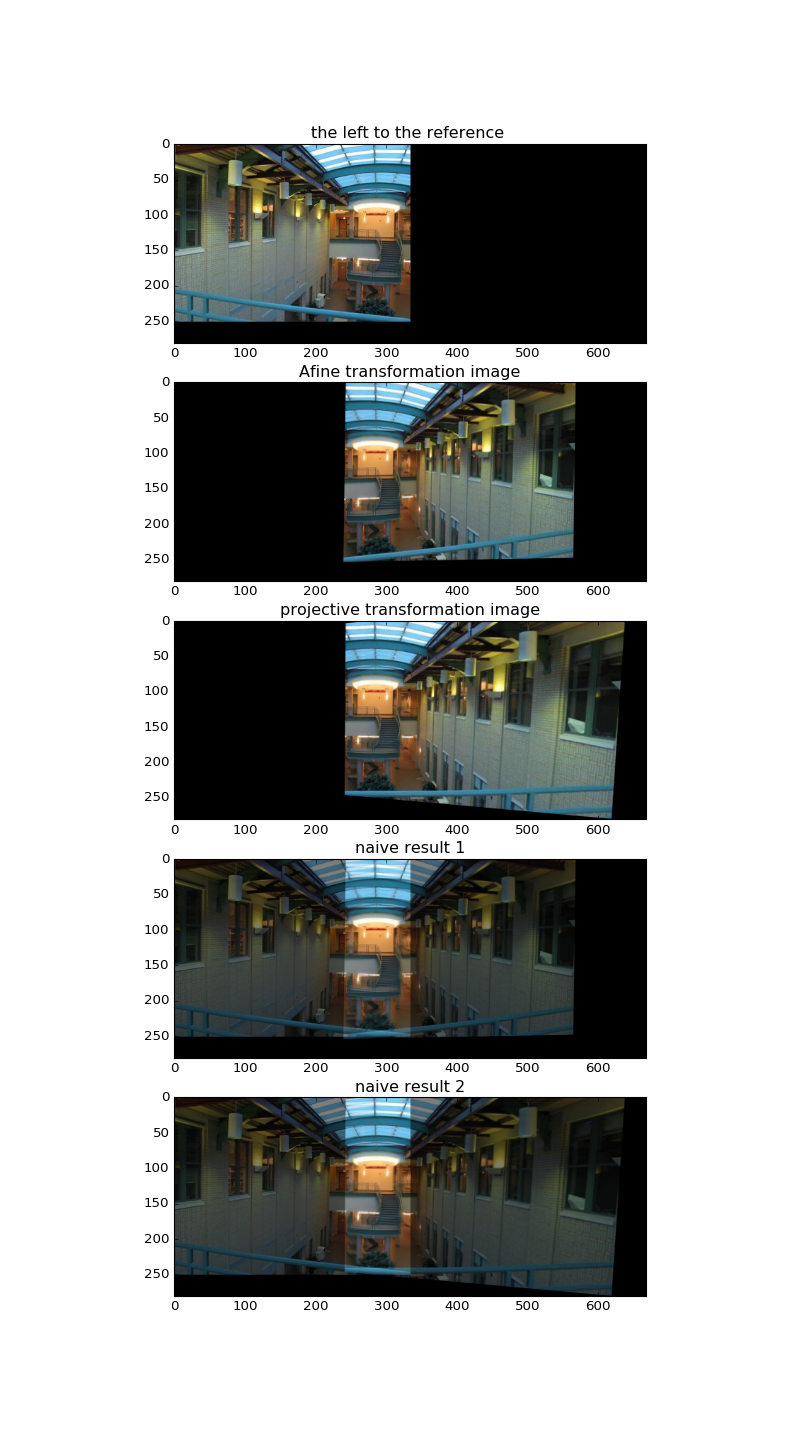

In [9]:
fig2 = plt.figure(3,figsize = (10, 18))
ax51 = fig2.add_subplot(511)
ax51.imshow(LtoRef)
ax51.set_title("the left to the reference ")

ax52 = fig2.add_subplot(512)
ax52.imshow(RaffRef)
ax52.set_title("Afine transformation image")

ax53 = plt.subplot(513)
ax53.imshow(RprjRef)
ax53.set_title("projective transformation image")

ax54 = plt.subplot(514)
ax54.imshow(result)
ax54.set_title("naive result 1")

ax55 = plt.subplot(515)
ax55.imshow(result2)
ax55.set_title("naive result 2")

plt.show()

## CrossDissove and Compare results

Using cross Dissove to visualize the two diffferent implementations


<IPython.core.display.Javascript object>


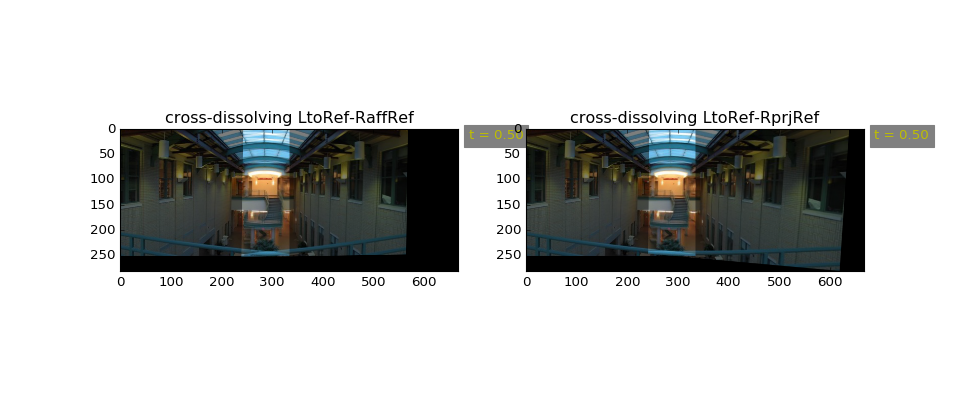

In [10]:
from skimage.transform import resize
fig = plt.figure(4,figsize = (12, 5))
ax12 = plt.subplot(121)
css12 = CrossDissolver(ax12,LtoRef,RaffRef,'float')  # instantiates CrossDissolver 
plt.title("cross-dissolving LtoRef-RaffRef")

ax34 = plt.subplot(122)
css34 = CrossDissolver(ax34,LtoRef,RprjRef,'float')#
plt.title("cross-dissolving LtoRef-RprjRef")

## Discussion

Compare the results, the one that maps better is the projective transformation 

The reason is that projective transformation offers a more natural way for image warping because it is supposed to be how we perceive an image. Also it has a degree of 8 parameters for homographies. The images are projected to the same plane, hence the projective transformation should achieve a better result with the same optical centre

### Blending

In [11]:
    # This function compute a distance map from the boundary of an image.
    # It returns a numpy array of the same size as image with distances from each pixel to the border (float values)
    # which is also called distance transform--distance mapping
    
    def boundaryDT(image):
        # we want to use Euclidean distance with 4 neibours, two passes
        # or not..
        # four directions, up is row number starting from 1, each step increasing 1, so that would be i + 1
        # down would be shape.width - i -1 
        # left would just be 1 + j
        # right would just be shape.height - j - 1
        # that would be the closest side of the four, we would assign that to the ditance map     
        distance = np.full(image.shape,fill_value = 1.0, dtype = np.float)
        row = image.shape[0]
        col = image.shape[1]
        for i in np.arange(row):
            for j in np.arange(col):
                # left up right down
                distance[i,j] = np.array([(i+1),abs((col-i-1)),(j+1),abs((row-j-1))]).min()
        return distance

In [12]:
# computing boundary distance map/transform (bdt) for two images
Ldt = boundaryDT(imL)
Rdt = boundaryDT(imR)
# print Rdt[250,330]
LdtRef = warp(Ldt, np.identity(3), output_shape = shapeRef)
# project/warp Rdt image (distance masp) into the reference frame to obtain  RdtRef
RdtRef = warp(Rdt,PrjLtoR,output_shape = shapeRef)
r = LdtRef + RdtRef
# print r[280,600]
# print LdtRef.shape
# print RdtRef.shape
# when debugging, you can visulaize your LdtRef and RdtRef below to check if you are getting expected results 

## Visualizing LdtRef and RdtRef and result

<IPython.core.display.Javascript object>


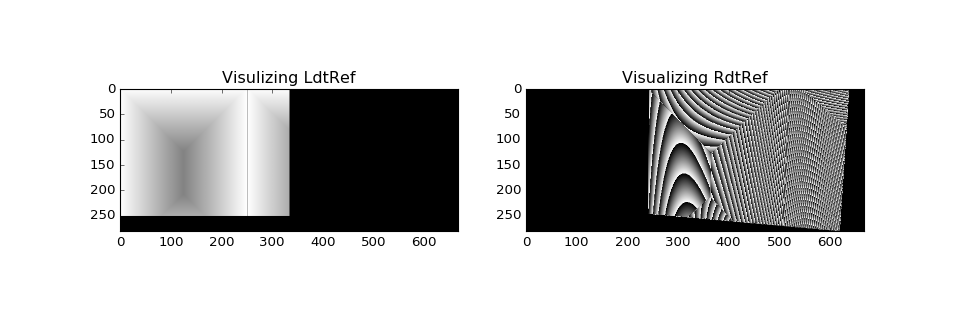

In [13]:
fig3 = plt.figure(5,figsize = (12, 4))
axL11 = plt.subplot(121)
axL11.imshow(LdtRef)
axL11.set_title("Visulizing LdtRef")

axR11 = plt.subplot(122)
axR11.imshow(RdtRef)
axR11.set_title("Visualizing RdtRef")

# axR21 = plt.subplot(133)
# axR21.imshow(r)
# axR21.set_title("Visualizing sum")

plt.show()

In [14]:
# you should generate a mosaic by blending two images LtoRef and RprjRef
# USE TWO DIFFERENT BLENDING alphas (AS IN TOPIC 9) AND COMPARE YOUR RESULTS 
# (SHOW THE RESULTS AND DISCUSS THE DIFFERENCES IN A MARKDOWN CELL BELOW)

# METHOD 1: averaging intensities of two images in the overlap area
def average(img1,img2):
    result = np.zeros(img1.shape)
    for i in np.arange(img1.shape[0]):
        for j in np.arange(img1.shape[1]):
            if img1[i,j][0] != 0.0 and img2[i,j][0] != 0.0:
                average = (img1[i,j] + img2 [i,j]) / 2
                result[i,j] = average
            if img1[i,j][0] != 0.0 and img2[i,j][0] == 0.0:
                result[i,j] = img1[i,j]
            if img1[i,j][0] == 0.0 and img2[i,j][0] != 0.0:
                result[i,j] = img2[i,j]
    return result

# METHOD 2: DT-weighted averaging in the overlap area (using LdtRef and RdtRef generated above)

# this one is the logical one
def weight_average(img1,img2):
    result = np.zeros(img1.shape)
    for i in np.arange(img1.shape[0]):
        for j in np.arange(img1.shape[1]):
            if img1[i,j][0] != 0.0 and img2[i,j][0] != 0.0:
                if LdtRef[i,j][0] > RdtRef[i,j][0]:
                    result[i,j] = img2[i,j]
                else:
                    result[i,j] = img1[i,j]              
            if img1[i,j][0] != 0.0 and img2[i,j][0] == 0.0:
                result[i,j] = img1[i,j]
            if img1[i,j][0] == 0.0 and img2[i,j][0] != 0.0:
                result[i,j] = img2[i,j]
    return result
# This is the other one
def weight_average2(img1,img2):
    result = np.zeros(img1.shape)
    for i in np.arange(img1.shape[0]):
        for j in np.arange(img1.shape[1]):
            if img1[i,j][0] != 0.0 and img2[i,j][0] != 0.0:
                    result[i,j] = img2[i,j] * (LdtRef[i,j][0]/( LdtRef[i,j][0] + RdtRef[i,j][0])) * 1.5
            if img1[i,j][0] != 0.0 and img2[i,j][0] == 0.0:
                result[i,j] = img1[i,j]
            if img1[i,j][0] == 0.0 and img2[i,j][0] != 0.0:
                result[i,j] = img2[i,j]
    return result
    

# numpy HINT 1: if you have an array "alpha" of shape (w,h) with scalers for each pixel 
#               of an RGB image A, which is an array of shape (w,h,3), then
#               you can use np.dstack((alpha,alpha,alpha)) to generate an array of shape (w,h,3)
#               assuming that you use the same slaler for R, G, and B values in each pixel
# numpy HINT 2: you can use operator A*B for pointwise multiplication of two matrices of the same shape
#               It returns array of the same shape where each element is the product of the corresponding elements in A and B
# numpy HINT 3: you can add the same scalar a to all elements in matrix A using a+A operation

## Results and discussions 

## Blending with averaging

<IPython.core.display.Javascript object>


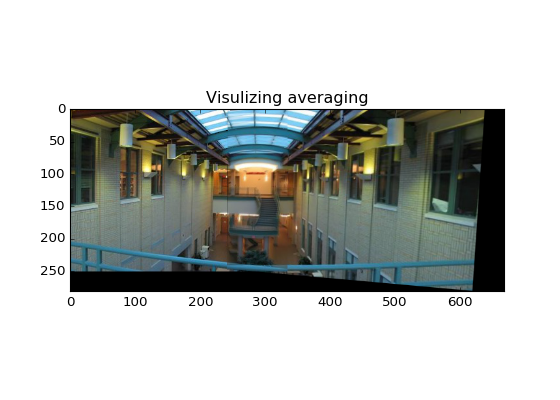

In [15]:
fig = plt.figure(7,figsize = (7, 5))
ax12 = plt.subplot(111)
result = average(LtoRef,RprjRef)
ax12.imshow(result)
ax12.set_title("Visulizing averaging")
plt.show()

## Blending with distance transform

<IPython.core.display.Javascript object>


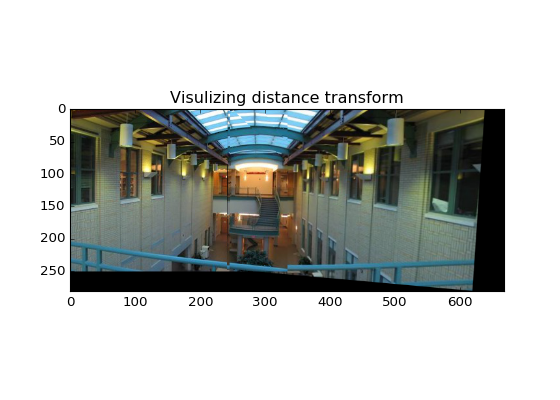

In [16]:
fig = plt.figure(8,figsize = (7, 5))
ax12 = plt.subplot(111)
result = weight_average(LtoRef,RprjRef)
ax12.imshow(result)
ax12.set_title("Visulizing distance transform")
plt.show()

## Blending3

<IPython.core.display.Javascript object>


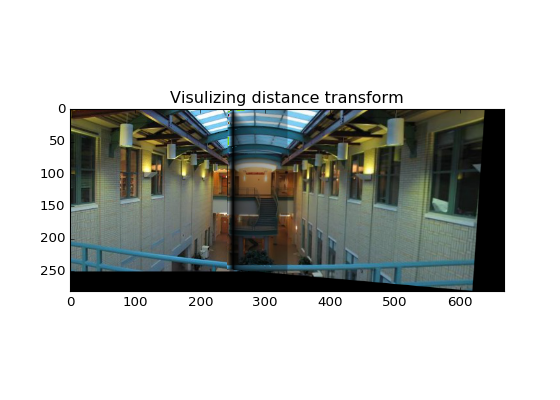

In [17]:
fig = plt.figure(9,figsize = (7, 5))
ax12 = plt.subplot(111)
result = weight_average2(LtoRef,RprjRef)
ax12.imshow(result)
ax12.set_title("Visulizing distance transform")
plt.show()

## Discussions the difference

The difference with different blending methods.

For the averaging method, we can see it achieves a good effect that only the edges area seems artifical, because depends on the projective images, the edge areas are usually where the intensities spread unevenly, that's why it looks very artifical there.

For the distance transform uses logical expression that it also achieves desent result, but the program is still in the edge areas. There should be a additional step to smooth the edge 

As for the distance transfrom of the form (distance1)/(distance1 + distance2),it doesn't seem right